## XGBoost - Predicting Housing Prices using SageMaker's Low Level Python API
* Project: To predict the median value of a home in the area of Boston Mass using XGBoost Model, in SageMaker, using Low Level Python API
* Dataset:[Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)
* Documentation: [Low level API documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/)
* Author: Shashi Kiran Chilukuri

### Steps followed to create, train, test, deploy model
1. Importing Python libraries, modules & sagemaker objects
2. Download or otherwise retrieve the data.
3. Process / Prepare the data.
4. Upload the processed data to S3.
5. Train a chosen model.
6. Test the trained model (typically using a batch transform job).
7. Deploy the trained model.
8. Use the deployed model.
---

## Step 1: Importing Python libraries, modules & sagemaker objects

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

%matplotlib inline

import time
from time import gmtime, strftime

# Importing Sagemaker objects
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# Session gives currently operating session details
session = sagemaker.Session()

# role gives 'IAM role' that we are currently assigned. This will be useful constructing
# and launching the training job
role = get_execution_role()

## Step 2: Downloading the data
Bosting Housing dataset can be retrieved using sklearn

In [2]:
boston = load_boston()

## Step 3: Preparing and splitting the data

Given that this is clean tabular data, we don't need to do any processing. However, we do need to split the rows in the dataset up into train, test and validation sets. 

Note: XGBoost is prone to overfitting, to avoid that we are validation data

In [3]:
# Creating the dataframes for inputs and targets 
X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# Splitting dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Splitting training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## Step 4: Uploading the data files to S3

When a training job is constructed using SageMaker, a container is executed which performs the training operation. This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. In addition, when we perform a batch transform job, SageMaker expects the input data to be stored on S3. We can use the SageMaker API to do this and hide some of the details.

**Save the data locally:** First we need to create the test, train and validation csv files which we will then upload to S3.

In [4]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [5]:
# Saving as test, train, validation csv files
# Note that we make sure not to include header information or an index 

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

**Upload to S3:** Upload our data to the 'default' S3 bucket and addinga custom prefix

In [6]:
prefix = 'boston-xgboost-LL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Step 5: Train and construct the XGBoost model

Now that we have the training and validation data uploaded to S3, we can construct a training job for our XGBoost model and build the model itself.

### Set up the training job

First, we will set up and execute a training job for our model. To do this we need to specify some information that SageMaker will use to set up and properly execute the computation. For additional documentation on constructing a training job, see the [CreateTrainingJob API](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html) reference.

In [7]:
# Using `get_image_uri` utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')

# We now specify the parameters we wish to use for our training job
training_params = {}

# We need to specify the permissions that this training job will have. For our purposes we can use
# the same permissions that our current SageMaker session has.
training_params['RoleArn'] = role

# Here we describe the algorithm we wish to use. The most important part is the container which
# contains the training code.
training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

# We also need to say where we would like the resulting model artifacts stored.
training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

# We also need to set some parameters for the training job itself. Namely we need to describe what sort of
# compute instance we wish to use along with a stopping condition to handle the case that there is
# some sort of error and the training script doesn't terminate.
training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

# Next we set the algorithm specific hyperparameters. You may wish to change these to see what effect
# there is on the resulting model.
training_params['HyperParameters'] = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

# Now we need to tell SageMaker where the data should be retrieved from.
training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

### Execute the training job

Now that we've built the dictionary object containing the training job parameters, we can ask SageMaker to execute the job.

In [10]:
# First we need to choose a training job name. This is useful for if we want to recall information about our
# training job at a later date. Note that SageMaker requires a training job name and that the name needs to
# be unique, which we accomplish by appending the current timestamp.
training_job_name = "boston-xgboost-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# And now we ask SageMaker to create (and execute) the training job
training_job = session.sagemaker_client.create_training_job(**training_params)

The training job has now been created by SageMaker and is currently running. Since we need the output of the training job, we may wish to wait until it has finished. We can do so by asking SageMaker to output the logs generated by the training job and continue doing so until the training job terminates.

In [11]:
session.logs_for_job(training_job_name, wait=True)

2019-01-24 18:22:23 Starting - Launching requested ML instances......
2019-01-24 18:23:22 Starting - Preparing the instances for training...
2019-01-24 18:24:06 Downloading - Downloading input data...
2019-01-24 18:24:13 Training - Downloading the training image.
Arguments: train
[2019-01-24:18:24:40:INFO] Running standalone xgboost training.
[2019-01-24:18:24:40:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8442.17mb
[2019-01-24:18:24:40:INFO] Determined delimiter of CSV input is ','
[18:24:40] S3DistributionType set as FullyReplicated
[18:24:40] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-01-24:18:24:40:INFO] Determined delimiter of CSV input is ','
[18:24:40] S3DistributionType set as FullyReplicated
[18:24:41] 112x13 matrix with 1456 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[18:24:41] src/tree/updater_prune.cc:74: tree pr

### Build the model

Now that the training job has completed, we have some model artifacts which we can use to build a model. Note that here we mean SageMaker's definition of a model, which is a collection of information about a specific algorithm along with the artifacts which result from a training job.

In [12]:
# We begin by asking SageMaker to describe for us the results of the training job. The data structure
# returned contains a lot more information than we currently need, try checking it out yourself in
# more detail.
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [13]:
# Just like when we created a training job, the model name must be unique
model_name = training_job_name + "-model"

# We also need to tell SageMaker which container should be used for inference and where it should
# retrieve the model artifacts from. In our case, the xgboost container that we used for training
# can also be used for inference.
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

# And lastly we construct the SageMaker model
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

## Step 6: Test the model

To test our trained model, we will make use of SageMaker's Batch Transform functionality. To start with, we need to build a transformer object from our fit model.constructed the training job earlier.

### Set up the batch transform job

Just like when we were training our model, we first need to provide some information in the form of a data structure that describes the batch transform job which we wish to execute.

We will only be using some of the options available here but to see some of the additional options please see the SageMaker documentation for [creating a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTransformJob.html).

In [14]:
# Just like in each of the previous steps, we need to make sure to name our job and the name should be unique.
transform_job_name = 'boston-xgboost-batch-transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Now we construct the data structure which will describe the batch transform job.
transform_request = \
{
    "TransformJobName": transform_job_name,
    
    # This is the name of the model that we created earlier.
    "ModelName": model_name,
    
    # This describes how many compute instances should be used at once. If you happen to be doing a very large
    # batch transform job it may be worth running multiple compute instances at once.
    "MaxConcurrentTransforms": 1,
    
    # This says how big each individual request sent to the model should be, at most. One of the things that
    # SageMaker does in the background is to split our data up into chunks so that each chunks stays under
    # this size limit.
    "MaxPayloadInMB": 6,
    
    # Sometimes we may want to send only a single sample to our endpoint at a time, however in this case each of
    # the chunks that we send should contain multiple samples of our input data.
    "BatchStrategy": "MultiRecord",
    
    # This next object describes where the output data should be stored. Some of the more advanced options which
    # we don't cover here also describe how SageMaker should collect output from various batches.
    "TransformOutput": {
        "S3OutputPath": "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)
    },
    
    # Here we describe our input data. Of course, we need to tell SageMaker where on S3 our input data is stored, in
    # addition we need to detail the characteristics of our input data. In particular, since SageMaker may need to
    # split our data up into chunks, it needs to know how the individual samples in our data file appear. In our
    # case each line is its own sample and so we set the split type to 'line'. We also need to tell SageMaker what
    # type of data is being sent, in this case csv, so that it can properly serialize the data.
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_location,
            }
        }
    },
    
    # And lastly we tell SageMaker what sort of compute instance we would like it to use.
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

### Execute the batch transform job

Now that we have created the request data structure, it is time to ask SageMaker to set up and run our batch transform job. Just like in the previous steps, SageMaker performs these tasks in the background so that if we want to wait for the transform job to terminate (and ensure the job is progressing) we can ask SageMaker to wait of the transform job to complete.

In [15]:
transform_response = session.sagemaker_client.create_transform_job(**transform_request)

In [17]:
transform_desc = session.wait_for_transform_job(transform_job_name)

....!


### Analyze the results

Now that the transform job has completed, the results are stored on S3 as we requested. Since we'd like to do a bit of analysis in the notebook we can use some notebook magic to copy the resulting output from S3 and save it locally.

In [18]:
transform_output = "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)

In [19]:
!aws s3 cp --recursive $transform_output $data_dir

download: s3://sagemaker-us-east-2-637354651523/boston-xgboost-LL/batch-bransform/test.csv.out to ../data/boston/test.csv.out


To see how well our model works we can create a simple scatter plot between the predicted and actual values. If the model was completely accurate the resulting scatter plot would look like the line $x=y$. As we can see, our model seems to have done okay but there is room for improvement.

In [20]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0.5,1,'Median Price vs Predicted Price')

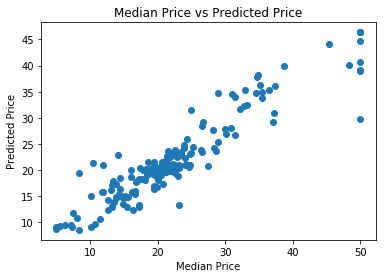

In [21]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## Step 7: Create and deploy the endpoint

Now that we have trained and constructed a model it is time to build the associated endpoint and deploy it. As in the earlier steps, we first need to construct the appropriate configuration.

In [22]:
# As before, we need to give our endpoint configuration a name which should be unique
endpoint_config_name = "boston-xgboost-endpoint-config-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# And then we ask SageMaker to construct the endpoint configuration
endpoint_config_info = session.sagemaker_client.create_endpoint_config(
                            EndpointConfigName = endpoint_config_name,
                            ProductionVariants = [{
                                "InstanceType": "ml.m4.xlarge",
                                "InitialVariantWeight": 1,
                                "InitialInstanceCount": 1,
                                "ModelName": model_name,
                                "VariantName": "AllTraffic"
                            }])

**NOTE:** When deploying a model you are asking SageMaker to launch an compute instance that will wait for data to be sent to it. As a result, this compute instance will continue to run until **you** shut it down. This is important to know since the cost of a deployed endpoint depends on how long it has been running for. In other words **If you are no longer using a deployed endpoint, shut it down!**

In [23]:
# Again, we need a unique name for our endpoint
endpoint_name = "boston-xgboost-endpoint-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# And then we can deploy our endpoint
endpoint_info = session.sagemaker_client.create_endpoint(
                    EndpointName = endpoint_name,
                    EndpointConfigName = endpoint_config_name)

Just like when we created a training job, SageMaker is now requisitioning and launching our endpoint. Since we can't do much until the endpoint has been completely deployed we can wait for it to finish.

In [24]:
endpoint_dec = session.wait_for_endpoint(endpoint_name)

--------------------------------------------------------------!

## Step 8: Use the model
We can evaluate the results here 

In [25]:
# First we need to serialize the input data. In this case we want to send the test data as a csv and
# so we manually do this. Of course, there are many other ways to do this.
payload = [[str(entry) for entry in row] for row in X_test.values]
payload = '\n'.join([','.join(row) for row in payload])

In [26]:
# This time we use the sagemaker runtime client rather than the sagemaker client so that we can invoke
# the endpoint that we created.
response = session.sagemaker_runtime_client.invoke_endpoint(
                                                EndpointName = endpoint_name,
                                                ContentType = 'text/csv',
                                                Body = payload)

# We need to make sure that we deserialize the result of our endpoint call.
result = response['Body'].read().decode("utf-8")
Y_pred = np.fromstring(result, sep=',')

Text(0.5,1,'Median Price vs Predicted Price')

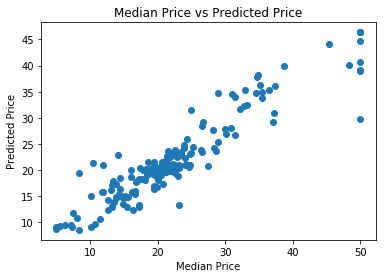

In [27]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## Delete the endpoint and clean up the disk space

Since we are no longer using the deployed model we need to make sure to shut it down. Remember that you have to pay for the length of time that your endpoint is deployed so the longer it is left running, the more it costs

In [28]:
session.sagemaker_client.delete_endpoint(EndpointName = endpoint_name)

{'ResponseMetadata': {'RequestId': '18edc4c8-5432-48f4-91bb-82a6d6ea1c1c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '18edc4c8-5432-48f4-91bb-82a6d6ea1c1c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 24 Jan 2019 18:40:14 GMT'},
  'RetryAttempts': 0}}

In [29]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir